# Waveguide size converter

Run this notebook in your browser using [Binder](https://mybinder.org/v2/gh/flexcompute-readthedocs/tidy3d-docs/readthedocs?labpath=docs%2Fsource%2Fnotebooks%2FWaveguideSizeConverter.ipynb).

Note: the cost of running the entire notebook is larger than 1 FlexUnit.

It is common to have waveguide components of different widths and potentially thicknesses on a photonic integrated circuit (PIC). Therefore, having a low-loss waveguide size converter becomes a necessity. The most common and simple size converter is adiabatic waveguide tapers. However, to achieve low loss and meet the adiabatic condition, the taper inevitable needs to be very long, which is not ideal in many modern high-density PIC designs. To aleviate this shortcoming of the conventional adiabatic taper, novel designs of compact size converter have emerged. 

In this notebook, we aim to simulate different types of size converters and compare their performance. We first simulate linear adiabatic tapers of different lengths. Subsequently, we will demonstrate two compact designs: one based on Luneburg lens and the other based on semi-lens emerged from segment optimization. These novel designs achieve ~-0.5 dB loss while being only about 6$\lambda_0$ in footprint. Linear adiabatic taper can only achieve similar performance while being 30$\lambda_0$ long.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins import ModeSolver

[19:56:01] INFO     Using client version: 1.8.1                               ]8;id=487572;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/__init__.py\__init__.py]8;;\:]8;id=269682;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/__init__.py#112\112]8;;\

To suppress unnecessary warnings, we set the logging level to 'error'.

In [2]:
td.config.logging_level = "error"

Define the simulation wavelength (frequency) range.

In [3]:
lda0 = 1.55  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
ldas = np.linspace(1.5, 1.6, 101)  # wavelength range
freqs = td.C_0 / ldas  # frequency range
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))  # width of the frequency distribution

All devices simulated in this notebook are based on silicon waveguide on a thick oxide layer. We define both materials as nondispersive since the simulation wavelength range is relatively small.

In [4]:
n_si = 3.48  # silicon refractive index
si = td.Medium(permittivity=n_si**2)

n_sio2 = 1.44  # silicon oxide refractive index
sio2 = td.Medium(permittivity=n_sio2**2)

## Linear Taper 

The most straightforward way to connect two waveguides of different widths is via an adiabatic taper. The taper shape can be linear, hyperbolic, Gaussian, and so on. Here, we demonstrate a linear taper and investigate how the loss scales with taper length. To be specific, we model a taper connecting the input waveguide of 10 $\mu m$ wide to an output waveguide of 500 nm wide. Both waveguides have the same thickness of 110 nm. TE0 mode is launched at the input waveguide.

Since we would like to perform a parameter sweep over the taper length, we will define a function called `linear_taper_sim` to construct the simulation. This function will be called repeatedly to make a simulation batch. The structure of the taper including the input and output waveguides can be conveniently made using as a [PolySlab](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.PolySlab.html?highlight=polyslab).

<img src="img/linear_taper.png" width="500">

In [5]:
w_in = 10  # input waveguied width
w_out = 0.5  # output waveguide width
t_wg = 0.11  # waveguide thickness
inf_eff = 1e3  # effective infinity of the model

# define the substrate structure
sub = td.Structure(
    geometry=td.Box.from_bounds(rmin=(-inf_eff, -inf_eff, -inf_eff), rmax=(inf_eff, inf_eff, 0)),
    medium=sio2,
)

# define a function to construct the simulation given the taper length
def linear_taper_sim(L_t):

    # vertices of the taper
    vertices = [
        [-inf_eff, w_in / 2],
        [0, w_in / 2],
        [L_t, w_out / 2],
        [inf_eff, w_out / 2],
        [inf_eff, -w_out / 2],
        [L_t, -w_out / 2],
        [0, -w_in / 2],
        [-inf_eff, -w_in / 2],
    ]

    # construct the taper structure using a PolySlab
    linear_taper = td.Structure(
        geometry=td.PolySlab(vertices=vertices, axis=2, slab_bounds=(0, t_wg)), medium=si
    )

    # add a mode source that launches the TE0 mode at the input waveguide
    mode_source = td.ModeSource(
        center=(-lda0 / 2, 0, t_wg / 2),
        size=(0, 1.2 * w_in, 6 * t_wg),
        source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
        direction="+",
        mode_spec=td.ModeSpec(num_modes=1, target_neff=n_si),
        mode_index=0,
    )

    # add a field monitor to visualize the field distribution at z=t_wg/2
    field_monitor = td.FieldMonitor(
        center=(0, 0, t_wg / 2), size=(td.inf, td.inf, 0), freqs=[freq0], name="field"
    )

    # add a flux monitor to measure transmission to the output waveguide
    flux_monitor = td.FluxMonitor(
        center=(lda0 / 2 + L_t, 0, t_wg / 2),
        size=(0, 2 * w_out, 6 * t_wg),
        freqs=freqs,
        name="flux",
    )

    # define simulation domain size
    Lx = L_t + 2 * lda0
    Ly = w_in + 2 * lda0
    Lz = t_wg + 1.5 * lda0
    sim_size = (Lx, Ly, Lz)

    run_time = 3e-12  # run time of the simulation

    # define simulation
    sim = td.Simulation(
        center=(L_t / 2, 0, t_wg),
        size=sim_size,
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=20, wavelength=lda0),
        structures=[linear_taper, sub],
        sources=[mode_source],
        monitors=[field_monitor, flux_monitor],
        run_time=run_time,
        boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),  # pml is used in all boundaries
        symmetry=(0, -1, 0),
    )  # a pec symmetry plane at y=0 can be used to reduce the grid points of the simulation
    return sim

With the `linear_taper_sim` function defined, we can use it to construct a simulation batch. We aim to simulate taper lengths of 10 $\mu m$, 20 $\mu m$, 50 $\mu m$, and 100 $\mu m$.

To visually verify the simulation setup, we can take a simulation from the batch and use the `plot` method.

<AxesSubplot: title={'center': 'cross section at z=0.06'}, xlabel='x', ylabel='y'>

<Figure size 432x288 with 1 Axes>

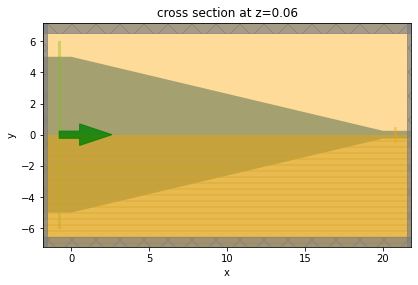

In [6]:
L_ts = np.array([10, 20, 50, 100])  # taper lengths to be simulated
sims = {f"L_t={L_t}": linear_taper_sim(L_t) for L_t in L_ts}  # make a simulation batch
sim = sims["L_t=20"]  # take one simulation (L_t=20) from the batch
sim.plot(z=t_wg / 2)  # visualize the simualtion setup

Submit the simulation batch to the server.

In [7]:
batch = web.Batch(simulations=sims)
batch_results = batch.run(path_dir="data")

Output()

Output()

Output()

Output()

[19:56:08] Started working on Batch.                                         ]8;id=108333;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/container.py\container.py]8;;\:]8;id=646843;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/container.py#361\361]8;;\

Output()

[19:58:14] Batch complete.                                                   ]8;id=948011;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/container.py\container.py]8;;\:]8;id=619260;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/container.py#382\382]8;;\

After the batch simulation is complete, we can see how the loss scales with the taper length. From the results, we can see that a 10 $\mu m$ taper has an insertion loss of ~-6 dB and a 20 $\mu m$ taper has an insertion loss of ~-3 dB. To achieve low loss, the taper needs to be longer than 50 $\mu m$, which is not sufficiently compact for many applications.

Output()

Output()

Output()

Output()

<matplotlib.legend.Legend object at 0x7f5d549c6130>

<Figure size 432x288 with 1 Axes>

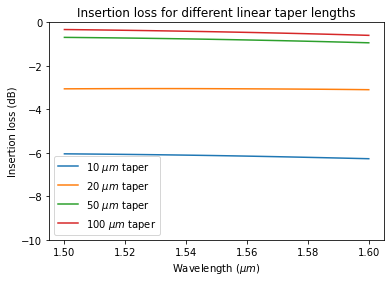

In [8]:
# using a for loop to plot the insertion losses at different taper lengths
for i, L_t in enumerate(L_ts):
    sim_data = batch_results[f"L_t={L_t}"]
    T = sim_data["flux"].flux
    plt.plot(ldas, 10 * np.log10(T), label=f"{L_t} $\mu m$ taper")

plt.title("Insertion loss for different linear taper lengths")
plt.ylim(-10, 0)
plt.xlabel("Wavelength ($\mu m$)")
plt.ylabel("Insertion loss (dB)")
plt.legend()

The field distributions can also be plotted. From the field distributions, we can see the leakage of energy at the abrupt changes where the taper meets the straight waveguide. This leakage is reduced for longer tapers and thus the insertion loss is smaller.

<Figure size 576x576 with 8 Axes>

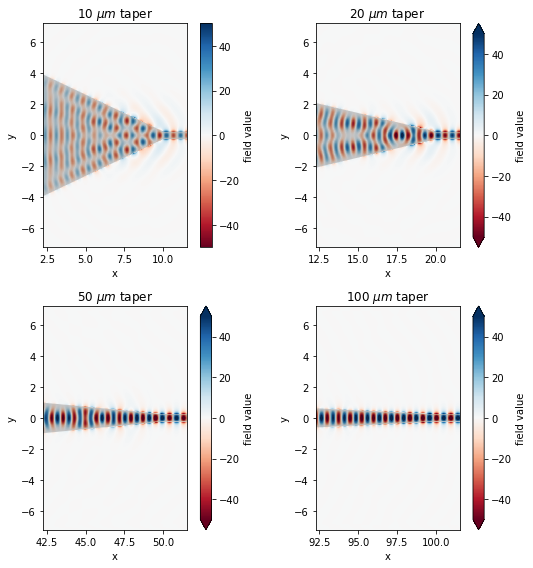

In [9]:
f, ax = plt.subplots(2, 2, tight_layout=True, figsize=(8, 8))
for i, L_t in enumerate(L_ts):
    sim_data = batch_results[f"L_t={L_t}"]
    sim_data.plot_field("field", "Ey", f=freq0, ax=ax[i // 2, i % 2], vmin=-50, vmax=50)
    ax[i // 2, i % 2].set_xlim(L_t - 5 * lda0, L_t + lda0)
    ax[i // 2, i % 2].set_title(f"{L_t} $\mu m$ taper")

## Luneburg Lens Size Converter

Besides adiabatic tapers, there are many novel size converter designs that can achieve both compactness and low loss. The first example is a taper design based on the principle of a Luneburg lens, which we will demonstrate here. 

A Luneburg lens is a spherical graded index lens where its refractive index varies with positions. The most common Luneburg lens employees a refractive index profile of $n(r)=\sqrt{2-(\frac{r}{R})^2}$, where $r$ is the distance to the center of the lens and $R$ is the radius of the lens. The result of the graded index is that light propagating parellel to the lens will be focused on the edge of the lens.

On the other hand, waveguides with different thicknesses have different effective indices. By applying the same principle of a classical Luneburg lens, we can design a spherical waveguide region where the thickness of the waveguide varies such that the effective index follows that of a Luneburg lens. Consequently, the incidet light from the input waveguide can be focused into the output waveguide and we achieve a low loss while having a small device footprint. The device design is adapted from [S Hadi Badri and M M Gilarlue 2019 J. Opt. 21 125802](https://iopscience.iop.org/article/10.1088/2040-8986/ab4fa3).

To use this design, we first need to obtain the relationship between the effective index and the waveguide thickness. Here, we ignore the effect of finite waveguide width and only consider the effective index of a slab waveguide. This will leave room for further optimization, which is another topic that we will not cover in this example notebook. We will first use the [ModeSolver](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/ModeSolver.html?highlight=mode%20solver) to solve for the effective index. Note that the effective index here is that of the waveguide, not to confuse with the effective index used in a 2.5D simulation. The simulation here will be performed in full 3D.

<img src="img/luneburg_lens_taper.png" width="500">

In [10]:
t_slabs = np.linspace(t_wg, 0.4, 30)  # range of slab waveguide thickness
n_eff = np.zeros(len(t_slabs))  # effective index of the slab waveguide

for i, t_slab in enumerate(t_slabs):
    # build the slab
    slab = td.Structure(
        geometry=td.Box.from_bounds(rmin=(-inf_eff, -inf_eff, 0), rmax=(inf_eff, inf_eff, t_slab)),
        medium=si,
    )

    # define simulation domain size
    Lx = lda0
    Ly = 0 
    Lz = 10 * t_slab
    sim_size = (Lx, Ly, Lz)

    # define simulation
    sim = td.Simulation(
        center=(0, 0, t_slab / 2),
        size=sim_size,
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=50, wavelength=lda0),
        structures=[slab, sub],
        sources=[],  # for mode solver, no source or monitor is needed
        monitors=[],
        run_time=1e-15,
        boundary_spec=td.BoundarySpec.pml(z=True),
    )  # pml is applied in z direction and
    # periodic condition is applied in other directions

    # define a mode solver
    mode_solver = ModeSolver(
        simulation=sim,
        plane=td.Box(center=(0, 0, t_slab / 2), size=(Lx, 0, Lz)),
        mode_spec=td.ModeSpec(num_modes=1, target_neff=n_si),
        freqs=[freq0],
    )
    # solve for the mode
    mode_data = mode_solver.solve()

    # add the effective index to the n_eff array
    n_eff[i] = np.array(mode_data.n_eff[0])

To order to obtain the waveguide thickness given an effective index, we perform a polynomial fitting using `Numpy`'s `polyfit` method to the effective index obtained from the previous step.

<matplotlib.legend.Legend object at 0x7f5d55a42310>

<Figure size 432x288 with 1 Axes>

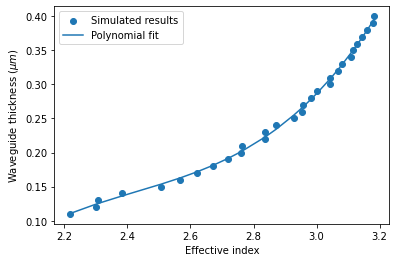

In [11]:
coefs = np.polyfit(n_eff, t_slabs, 3)
t_fit = np.poly1d(coefs)
plt.scatter(n_eff, t_slabs, label="Simulated results")
plt.plot(n_eff, t_fit(n_eff), label="Polynomial fit")
plt.xlabel("Effective index")
plt.ylabel("Waveguide thickness ($\mu m$)")
plt.legend()

We will construct a circular Luneburg lens region where the hight of the Si layer changes gradually such that the local effective index follows $n(r)=n_{edge}\sqrt{2-(\frac{r}{R})^2}$, where $n_{edge}$ is the effective index at the edge of the circle. To minimize impedance mismatch at the interface between the input/output waveguides and the Luneburg lens, the edge of the Luneburg lens will have the same thickness as the waveguides.

Text(0, 0.5, 'Si thickness ($\\mu m$)')

<Figure size 432x288 with 1 Axes>

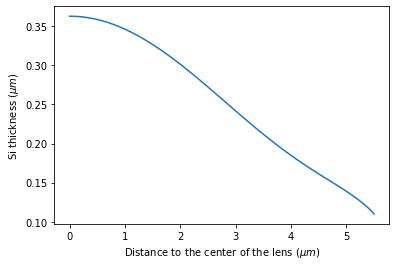

In [12]:
n_edge = n_eff[0]  # effective index at the edge of the luneburg lens
L_a = 11  # diameter of the luneburg lens region
R_lens = L_a / 2  # radius of the luneburg lens
r = np.linspace(0, R_lens, 100)  # distance to the center of the luneburg lens
n_lens = n_edge * np.sqrt(2 - (r / R_lens) ** 2)  # effective index of the luneburg lens
t_lens = t_fit(n_lens)  # thickness of the luneburg lens
t_lens[-1] = t_wg  # make sure the edge thickness is the same as the waveguide thickness

# plot the thickness profile of the luneburg lens
plt.plot(r, t_lens)
plt.xlabel("Distance to the center of the lens ($\mu m$)")
plt.ylabel("Si thickness ($\mu m$)")

From the above thickness profile, we can construct the Luneburg lens strucutre using a series of [Cylinders](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.Cylinder.html?highlight=cylinder). The radius and length of each cylinder follows the above plot. 

In [13]:
lens = []
for i in range(len(r)):
    lens.append(
        td.Structure(
            geometry=td.Cylinder(center=(0, 0, t_lens[i] / 2), radius=r[i], length=t_lens[i]),
            medium=si,
        )
    )

Build the input and output waveguides.

In [14]:
wg_in = td.Structure(
    geometry=td.Box.from_bounds(rmin=(-inf_eff, -w_in / 2, 0), rmax=(0, w_in / 2, t_wg)), medium=si
)
wg_out = td.Structure(
    geometry=td.Box.from_bounds(rmin=(0, -w_out / 2, 0), rmax=(inf_eff, w_out / 2, t_wg)), medium=si
)

<AxesSubplot: title={'center': 'cross section at z=0.03'}, xlabel='x', ylabel='y'>

<Figure size 432x288 with 1 Axes>

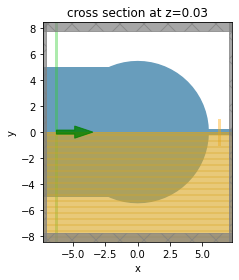

In [15]:
# define the simulation domain size
Lx = L_a + 2 * lda0
Ly = L_a + 3 * lda0
Lz = t_wg + 1.5 * lda0
sim_size = (Lx, Ly, Lz)

# add a mode source that launches the TE0 mode at the input waveguide
mode_source = td.ModeSource(
    center=(-lda0 / 2 - R_lens, 0, t_wg / 2),
    size=(0, 2 * w_in, 6 * t_wg),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0 / 10),
    direction="+",
    mode_spec=td.ModeSpec(num_modes=1, target_neff=n_si),
    mode_index=0,
)

# add a field monitor to visualize the field distribution at z=t_wg/2
field_monitor = td.FieldMonitor(
    center=(0, 0, t_wg / 2), size=(td.inf, td.inf, 0), freqs=[freq0], name="field"
)

# add a flux monitor to measure transmission to the output waveguide
flux_monitor = td.FluxMonitor(
    center=(lda0 / 2 + R_lens, 0, t_wg / 2), size=(0, 4 * w_out, 6 * t_wg), freqs=freqs, name="flux"
)

run_time = 2e-12  # simulation run time

# define simulation
sim = td.Simulation(
    center=(0, 0, t_wg / 2),
    size=sim_size,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=20, wavelength=lda0),
    structures=lens + [wg_in, wg_out, sub],
    sources=[mode_source],
    monitors=[field_monitor, flux_monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    symmetry=(0, -1, 0),
)

# visualize the simulation setup
sim.plot(z=t_wg/4)

Submit the simulation to the server.

In [16]:
job = web.Job(simulation=sim, task_name="luneburg_lens_taper")
sim_data = job.run(path="data/simulation_data.hdf5")

Output()

Output()

Output()

Output()

Output()

After the simulation is complete, we can visualize the field distribution. In the Luneburg lens region, the wave front converges into a focus and the coupling to the output waveguide is efficient.

<AxesSubplot: title={'center': 'cross section at z=0.06'}, xlabel='x', ylabel='y'>

<Figure size 432x288 with 2 Axes>

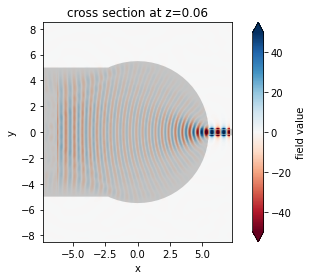

In [17]:
sim_data.plot_field("field", "Ey", vmin=-50, vmax=50)

More importantly, we need to quantitatively examine the insertion loss and compare that to a linear taper. The Luneburg lens is only about 10 $\mu m$ in length. Here, we plot the insertion loss of the Luneburg lens size converter to a 50 $\mu m$ linear taper. From the plot, we can see that the Luneburg lens outperforms the 50 $\mu m$ linear taper while being only 1/5 in size.

<matplotlib.legend.Legend object at 0x7f5d55a99580>

<Figure size 432x288 with 1 Axes>

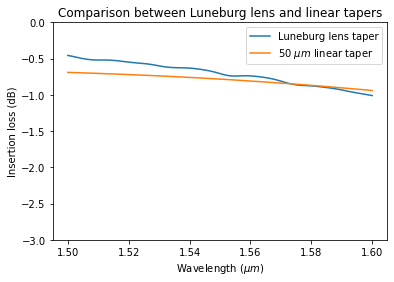

In [18]:
T_luneburg = sim_data["flux"].flux  # transmission of the luneburg lens
sim_data_linear = batch_results[f"L_t=50"]  # simulation of the 50 um lienar taper
T_linear = sim_data_linear["flux"].flux  # transmission of the linear taper

# plotting the insertion loss of the luneburg lens and the linear taper
plt.plot(ldas, 10 * np.log10(T_luneburg), label="Luneburg lens taper")
plt.plot(ldas, 10 * np.log10(T_linear), label="50 $\mu m$ linear taper")
plt.title("Comparison between Luneburg lens and linear tapers")
plt.ylim(-3, 0)
plt.xlabel("Wavelength ($\mu m$)")
plt.ylabel("Insertion loss (dB)")
plt.legend()

## Semi-lens Beam Expander 

The Luneburg lens design introduced in the previous section requires a more complicated fabrication since the thickness of the Si layer needs to gradually vary. This is not desirable in many cases. There are a number of other designs that circumvent this issue. One such example is introduced in [Siamak Abbaslou, Robert Gatdula, Ming Lu, Aaron Stein, and Wei Jiang, "Ultra-short beam expander with segmented curvature control: the emergence of a semi-lens," Opt. Lett. 42, 4383-4386 (2017)](https://opg.optica.org/ol/abstract.cfm?uri=ol-42-21-4383), where a compact waveguide taper is segmented into 6 segments and oarticle swarm optimization algorithm is used to optimize the shape of each segment. The result of the optimization is a semi-lens structure that also outperforms the conventional adiabatic taper of the same length by a great margin. 

In the previous models, the input waveguide is wider than the output waveguide. In this case, we model a beam expander so the output waveguide is 9 $\mu m$ wide and the input waveguide is 450 nm wide. 

<img src="img/semi_lens_taper.png" width="500">

In [19]:
t_wg = 0.26  # thickness of the waveguide
w_0 = 0.45  # width of the input waveguide
w_6 = 9  # width of the output waveguide

# optimized design parameters
m_i = [3, 1.1, 0.01, 3, 0.32, 2.55]
w_i = [w_0, 1.7, 3.3, 9.06, 10, 3.19, w_6]
L_i = [1, 3.61, 0.05, 0.7, 3.11, 1.03]

L_tot = np.sum(L_i)  # total length of the device

The width of each segment of the device is described by $w(x_i)=(w_i-w_{i+1})|\frac{x_i-L_i}{L_i}|^{m_i}$, where $i=1,2,...,6$, $w_i$ is the width at the begining of each segment, $L_i$ is the length of each segment, and $m_i$ is the curvature of each segment. The optimized values of $w_i$, $L_i$, and $m_i$ are listed above.

The structure of the deive will be constructed using a series of [PolySlabs](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.PolySlab.html?highlight=polyslab). The vertices are calculated from the above equation and the optimized parameters.

<Figure size 432x288 with 1 Axes>

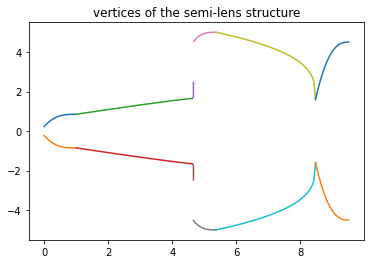

In [20]:
X = np.array([-inf_eff])  # x coordinate of the vertices
Y = np.array([w_0 / 2])  # y coordinate of the vertices

# obtain the vertices in the upper half of each segment
for i in range(6):
    if i == 0:
        x = np.linspace(0, L_i[0], 60)
    else:
        x = np.linspace(np.sum(L_i[0:i]), np.sum(L_i[0 : i + 1]), 60)
    x_i = x - np.sum(L_i[0:i])
    y = (w_i[i] - w_i[i + 1]) * np.abs((x_i - L_i[i]) / L_i[i]) ** m_i[i] + w_i[i + 1]
    X = np.append(X, x)
    Y = np.append(Y, y / 2)
    plt.plot(x, y / 2)
    plt.plot(x, -y / 2)

plt.title("vertices of the semi-lens structure")

# obtain the vertices in the lower half of the structure
X = np.append(X, inf_eff)
X = np.concatenate((X, np.flipud(X)))
Y = np.append(Y, w_6 / 2)
Y = np.concatenate((Y, -np.flipud(Y)))

vertices = np.transpose(np.vstack((X, Y)))

# construct the semi-lens structure using the above vertices
semi_lens = td.Structure(
    geometry=td.PolySlab(vertices=vertices, axis=2, slab_bounds=(0, t_wg)), medium=si
)

The simulation will be defined in a similar way as previou simulations. Since in this model, the output waveguide supports higher order modes, we add an additional [ModeMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.ModeMonitor.html) to investigate the mode composition at the output waveguide. Ideally, the fundamental TE mode should be dominant.

In [21]:
# define the simulation domain size
Lx = L_tot + 4 * lda0
Ly = np.max(w_i) + 4 * lda0
Lz = 10 * t_wg

sim_size = (Lx, Ly, Lz)

# add a mode source that launches the TE0 mode at the input waveguide
mode_spec = td.ModeSpec(num_modes=5, target_neff=n_si)
mode_source = td.ModeSource(
    center=(-lda0, 0, t_wg / 2),
    size=(0, 4 * w_0, 5 * t_wg),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0 / 10),
    direction="+",
    mode_spec=mode_spec,
    mode_index=0,
)

# add a field monitor to visualize the field distribution at z=t_wg/2
field_monitor = td.FieldMonitor(
    center=(0, 0, t_wg / 2), size=(td.inf, td.inf, 0), freqs=[freq0], name="field"
)

# add a flux monitor to measure transmission to the output waveguide
flux_monitor = td.FluxMonitor(
    center=(L_tot + 2 * lda0, 0, t_wg / 2), size=(0, 1.2 * w_6, 5 * t_wg), freqs=freqs, name="flux"
)

# add a mode source to measure the mode composition at the output waveguide
mode_monitor = td.ModeMonitor(
    center=(L_tot + 2 * lda0, 0, t_wg / 2),
    size=(0, 1.2 * w_6, 5 * t_wg),
    freqs=freqs,
    mode_spec=mode_spec,
    name="mode",
)

<AxesSubplot: title={'center': 'cross section at z=0.13'}, xlabel='x', ylabel='y'>

<Figure size 432x288 with 1 Axes>

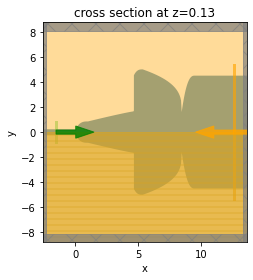

In [22]:
# define simulation
sim = td.Simulation(
    center=(L_tot / 2 + lda0 / 2, 0, t_wg / 2),
    size=sim_size,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=20, wavelength=lda0),
    structures=[semi_lens, sub],
    sources=[mode_source],
    monitors=[field_monitor, flux_monitor, mode_monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    symmetry=(0, -1, 0),
)

# visualize the simulation setup
sim.plot(z=t_wg / 2)

Submit the simulation to the server.

In [23]:
job = web.Job(simulation=sim, task_name="semi_lens_beam_expander")
sim_data = job.run(path="data/simulation_data.hdf5")

Output()

Output()

Output()

Output()

Output()

Plot the field distribution.

<AxesSubplot: title={'center': 'cross section at z=0.13'}, xlabel='x', ylabel='y'>

<Figure size 432x288 with 2 Axes>

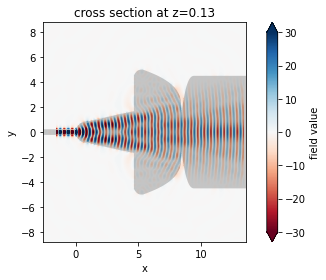

In [24]:
sim_data.plot_field("field", "Ey", vmin=-30, vmax=30)

Lastly, plot the insertion loss and the mode composition at the output waveguide. The insertion loss is about -0.5 dB, much better than the linear taper of the same length.

Due to the symmetry, the output power can only excite even TE modes. About 80% of the power is in the fundamental TE mode. The rest of the power is mostly in the TE2 mode.

<matplotlib.legend.Legend object at 0x7f5d54abe820>

<Figure size 720x360 with 2 Axes>

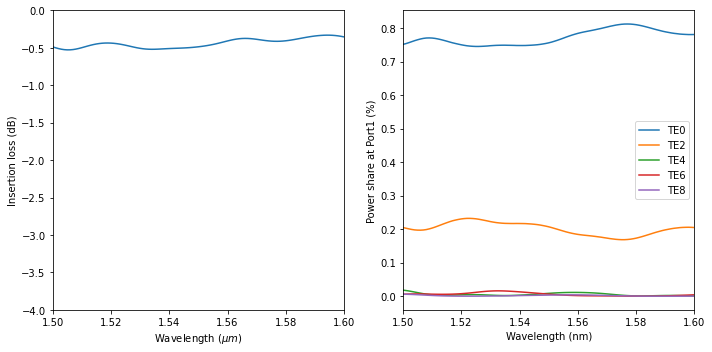

In [25]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 5))
T = sim_data["flux"].flux

plt.sca(ax1)
plt.plot(ldas, 10 * np.log10(T))
plt.xlim(1.5, 1.6)
plt.ylim(-4, 0)
plt.xlabel("Wavelength ($\mu m$)")
plt.ylabel("Insertion loss (dB)")

plt.sca(ax2)
mode_amp = sim_data["mode"].amps.sel(direction="+")
mode_power = np.abs(mode_amp) ** 2 / T
plt.plot(ldas, mode_power)
plt.xlim(1.5, 1.6)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Power share at Port1 (%)")
plt.legend(["TE0", "TE2", "TE4", "TE6", "TE8"])